# Connecting Charge Transfer Asymmetry to Surface Reconstruction induced Lattice Strain in Aged Ni-Rich NMC||C Cells


### Yuefan Ji and Daniel T. Schwartz<br>*Department of Chemical Engineering & Clean Energy Institute,<br>University of Washington*

# Supplementary Notebook

## Essential Packages and Functions

In [1]:
## editing system path to enable the load of nleis.py
import os.path
import sys
current_dir = os.path.dirname(os.path.abspath('__file__'))

# Get the parent directory by moving up one level
parent_dir = os.path.dirname(current_dir)
# Add the parent directory to the Python path
sys.path.append(parent_dir)

In [2]:
### basic package

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

### Basic impedance.py functionalities

from impedance.models.circuits import CustomCircuit
from impedance.models.circuits.elements import get_element_from_name
from impedance.models.circuits.fitting import check_and_eval

### import nleis.py functionalities
from nleis import EISandNLEIS, NLEISCustomCircuit
from nleis.nleis_fitting import data_processing
from nleis.visualization import plot_first,plot_second
from nleis.fitting import set_default_bounds
from nleis.validation import cost_max_norm

### formatting package
import time
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")


In [3]:
def SSO(ax1,ax2,Z1,Z2,f,initial_guess,circ_str_1,circ_str_2,bounds = None, sequential = False, max_f = 10,constants = None,cost = 0.5, opt='max'):
    # ### Data Processing
    f1,Z1, Z2, f2_trunc, Z2_trunc = data_processing(f,Z1,Z2,max_f = max_f)
    
    SSO_circuit = EISandNLEIS(circ_str_1,circ_str_2,initial_guess=initial_guess,constants = constants, graph = True)

    if sequential == True: 
        p1 = SSO_circuit.p1
        seq_constants ={}
        for key in constants:
            EIS_elem = key.replace('n','')
            raw_elem = get_element_from_name(EIS_elem)
            num = int(key.split('_')[1])
            raw_num = check_and_eval(raw_elem).num_params
            if num < raw_num:
                seq_constants[EIS_elem] = constants[key]
        EIS_circuit = CustomCircuit(circ_str_1, initial_guess=p1,constants=seq_constants)
        EIS_circuit.fit(f1,Z1)
        p1_fit = EIS_circuit.parameters_
        for x, replacement in zip(p1, p1_fit):
            idx = np.where(initial_guess == x)[0]  # Find indices of the value in p1
            if idx.size > 0:
                initial_guess[idx[0]] = replacement 
        SSO_circuit.initial_guess = initial_guess

    SSO_circuit.fit(f1,Z1,Z2,max_f=max_f,bounds = bounds, opt= opt ,cost = cost,param_norm = False)
    Z1_fit,Z2_fit = SSO_circuit.predict(f1,max_f= max_f)
    p1 = SSO_circuit.parameters_
    conf = SSO_circuit.conf_
    plot_first(ax1, Z1, fmt='o')
    plot_first(ax1, Z1_fit, fmt='-o',lw=3)
    ax1.text(0.73, 0.15, '$COST_{1} = $'+'{:0.1e}'.format(cost_max_norm(Z1,Z1_fit)), horizontalalignment='center',verticalalignment='center', transform=ax1.transAxes,size=16)
    ax1.legend(['Data','Model'],fontsize=16,loc='best')
    
    plot_second(ax2, Z2_trunc, fmt='o')
    plot_second(ax2, Z2_fit, fmt='-o',lw=3)
    ax2.text(0.73, 0.15, '$COST_{2} = $'+'{:0.1e}'.format(cost_max_norm(Z2_trunc,Z2_fit)), horizontalalignment='center',verticalalignment='center', transform=ax2.transAxes,size=16)
    ax2.legend(['Data','Model'],fontsize=16,loc='best')
    return Z1_fit,Z2_fit,p1,conf

def EIS(ax1,Z1,f,initial_guess,circ_str_1,bounds = None,constants = None):

    circuit = CustomCircuit(circ_str_1,initial_guess=initial_guess,constants = constants)
    sigma = np.ones(len(Z1)*2)*max(abs(Z1))
    circuit.fit(f,Z1,bounds = bounds,sigma=sigma)
    Z1_fit = circuit.predict(f)
    p1 = circuit.parameters_
    conf = circuit.conf_
    plot_first(ax1, Z1, fmt='o')
    plot_first(ax1, Z1_fit, fmt='-o',lw=3)
    ax1.text(0.73, 0.15, '$COST_{1} = $'+'{:0.1e}'.format(cost_max_norm(Z1,Z1_fit)), horizontalalignment='center',verticalalignment='center', transform=ax1.transAxes,size=16)
    ax1.legend(['Data','Model'],fontsize=16,loc='best')

    return Z1_fit,p1,conf    

In [4]:
path ='data/' 

In [5]:
ms = 10

In [6]:
fontsize= 16

# Fresh Cell Results

## Data

In [7]:
i= 51
f_f=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_freq.txt').view(float)

Z1_f10=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_Z1s_10_.txt').view(complex)
Z2_f10=np.loadtxt(path+'NLEIS_worked_up_data/Cell'+str(i)+'/Cell'+str(i)+'_Z2s_10_.txt').view(complex)
mask =Z1_f10.imag<0
f10 = f_f[mask]
Z1_f10 =  Z1_f10[mask]
Z2_f10 =  Z2_f10[mask]

Z1_f30=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_Z1s_30_.txt').view(complex)
Z2_f30=np.loadtxt(path+'NLEIS_worked_up_data/Cell'+str(i)+'/Cell'+str(i)+'_Z2s_30_.txt').view(complex)
mask =Z1_f30.imag<0
f30 = f_f[mask]
Z1_f30 =  Z1_f30[mask]
Z2_f30 =  Z2_f30[mask]

Z1_f50=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_Z1s_50_.txt').view(complex)
Z2_f50=np.loadtxt(path+'NLEIS_worked_up_data/Cell'+str(i)+'/Cell'+str(i)+'_Z2s_50_.txt').view(complex)
mask =Z1_f50.imag<0
f50 = f_f[mask]
Z1_f50 =  Z1_f50[mask]
Z2_f50 =  Z2_f50[mask]

## 10% SOC Results

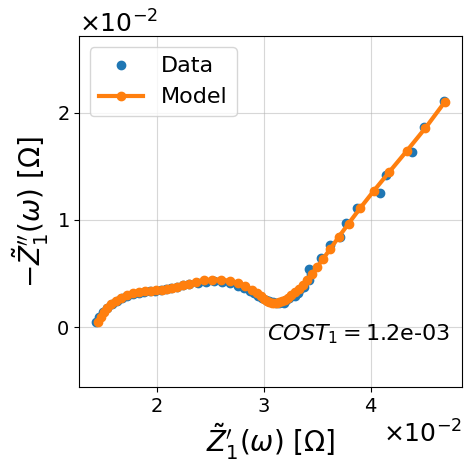

--- 0 mins 1.86 seconds ---


In [7]:
start_time = time.time()
### initialize the EIS and NLEIS string
### inductor in series with a resistor, a spherical cathode, and a planar anode
circ_str_1 = 'L0-R0-TDS0-TDP1' ## EIS string

L0 =1e-8;R0 = 0.01
Rpore = 0.02;Rct = 0.01;Cdl = 10;Aw = 1e-2;td = 10000

Rpore_a = .03;Rct_a = 1e-2;Cdl_a = 1;Aw_a = 1e-1;td_a =1000

initial_guess = np.array([L0,R0,Rpore,Rct,Cdl,Aw,td,
                          Rpore_a,Rct_a,Cdl_a,Aw_a,td_a])
fig, ax = plt.subplots(figsize=(5,5))

Z1_fit_f_10p,p1_f_10p,conf_f_10p = EIS(ax,Z1_f10,f10,initial_guess,circ_str_1,bounds = None,constants = None)

plt.tight_layout()
plt.show()
total_time = time.time() - start_time
print("--- %s mins " % int(total_time/60)+'%s seconds ---' % round(np.mod(total_time,60),2))


In [8]:
print('Parameters Set')

header=['L0','R0','Rpore,c','Rct,c','Cdl,c','Aw,c','τd,c']
print(tabulate([p1_f_10p[0:7]],headers=header))
header=['Rpore,a','Rct,a','Cdl,a','Aa','τa']
print(tabulate([p1_f_10p[7:]],headers=header))

Parameters Set
         L0         R0    Rpore,c       Rct,c    Cdl,c        Aw,c     τd,c
-----------  ---------  ---------  ----------  -------  ----------  -------
1.32604e-07  0.0125955  0.0542793  0.00216622   11.057  0.00137295  13.3805
  Rpore,a        Rct,a    Cdl,a         Aa       τa
---------  -----------  -------  ---------  -------
0.0384499  0.000930274  1.01019  0.0361038  650.619


In [9]:
print('Confidence Interval')

header=['L0','R0','Rpore,c','Rct,c','Cdl,c','Aw,c','τd,c']
print(tabulate([conf_f_10p[0:7]],headers=header))
header=['Rpore,a','Rct,a','Cdl,a','Aa','τa']
print(tabulate([conf_f_10p[7:]],headers=header))


Confidence Interval
         L0          R0    Rpore,c        Rct,c    Cdl,c        Aw,c     τd,c
-----------  ----------  ---------  -----------  -------  ----------  -------
1.45454e-08  0.00015126  0.0063675  0.000231064  1.22803  0.00126942  10.1699
  Rpore,a        Rct,a     Cdl,a         Aa       τa
---------  -----------  --------  ---------  -------
0.0107409  0.000275069  0.305926  0.0808574  2500.25


### Half-Cell Results

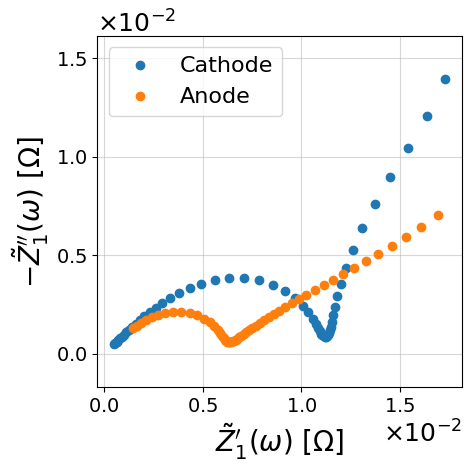

In [10]:
circuit = CustomCircuit()
circuit.circuit = 'TDS'
circuit.parameters_ = p1_f_10p[2:7]
Z1_10p_c = circuit.predict(f10)
circuit.circuit = 'TDP'
circuit.parameters_ = p1_f_10p[7:]
Z1_10p_a = circuit.predict(f10)

fig, ax = plt.subplots(figsize=(5,5))

plot_first(ax, Z1_10p_c, fmt='o')
plot_first(ax, Z1_10p_a, fmt='o')
plt.legend(['Cathode','Anode'],fontsize=16)
plt.tight_layout()
plt.show()

## 30% SOC Results

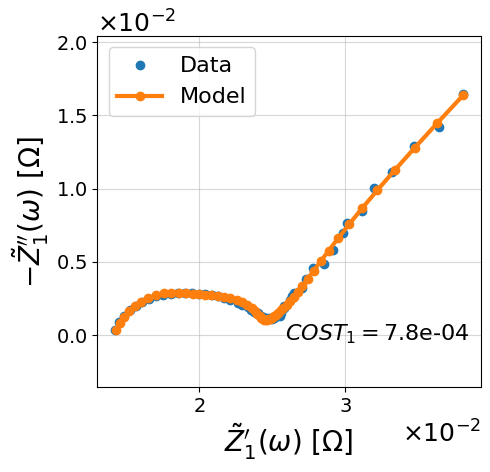

--- 0 mins 2.97 seconds ---


In [11]:
start_time = time.time()
### initialize the EIS and NLEIS string
### inductor in series with a resistor, a spherical cathode, and a planar anode
circ_str_1 = 'L0-R0-TDS0-TDP1' ## EIS string

initial_guess = p1_f_10p

fig, ax = plt.subplots(figsize=(5,5))

Z1_fit_f_30p,p1_f_30p,conf_f_30p= EIS(ax,Z1_f30,f30,initial_guess,circ_str_1,bounds = None,constants = None)

plt.tight_layout()
plt.show()
total_time = time.time() - start_time
print("--- %s mins " % int(total_time/60)+'%s seconds ---' % round(np.mod(total_time,60),2))


In [12]:
print('Parameters Set')

header=['L0','R0','Rpore,c','Rct,c','Cdl,c','Aw,c','τd,c']
print(tabulate([p1_f_30p[0:7]],headers=header))
header=['Rpore,a','Rct,a','Cdl,a','Aa','τa']
print(tabulate([p1_f_30p[7:]],headers=header))

Parameters Set
         L0        R0    Rpore,c        Rct,c    Cdl,c         Aw,c     τd,c
-----------  --------  ---------  -----------  -------  -----------  -------
1.39959e-07  0.012427  0.0676992  0.000449305  20.5456  9.36349e-05  3.61724
  Rpore,a       Rct,a     Cdl,a         Aa       τa
---------  ----------  --------  ---------  -------
0.0200161  0.00175875  0.475888  0.0584499  918.486


In [13]:
print('Confidence Interval')

header=['L0','R0','Rpore,c','Rct,c','Cdl,c','Aw,c','τd,c']
print(tabulate([conf_f_30p[0:7]],headers=header))
header=['Rpore,a','Rct,a','Cdl,a','Aa','τa']
print(tabulate([conf_f_30p[7:]],headers=header))


Confidence Interval
         L0           R0    Rpore,c        Rct,c    Cdl,c         Aw,c     τd,c
-----------  -----------  ---------  -----------  -------  -----------  -------
1.01464e-08  0.000115254   0.130076  0.000858397  39.1069  0.000182316  3.82756
   Rpore,a        Rct,a      Cdl,a        Aa       τa
----------  -----------  ---------  --------  -------
0.00230948  0.000271831  0.0639736  0.102153  3042.04


### Half-Cell Results

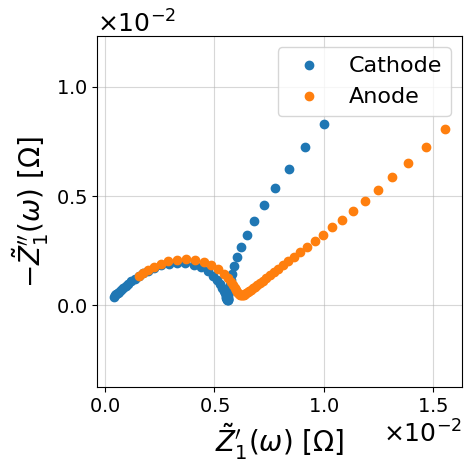

In [14]:
circuit = CustomCircuit()
circuit.circuit = 'TDS'
circuit.parameters_ = p1_f_30p[2:7]
Z1_30p_c = circuit.predict(f30)
circuit.circuit = 'TDP'
circuit.parameters_ = p1_f_30p[7:]
Z1_30p_a = circuit.predict(f30)

fig, ax = plt.subplots(figsize=(5,5))

plot_first(ax, Z1_30p_c, fmt='o')
plot_first(ax, Z1_30p_a, fmt='o')
plt.legend(['Cathode','Anode'],fontsize=16)
plt.tight_layout()
plt.show()

## 50% SOC Results

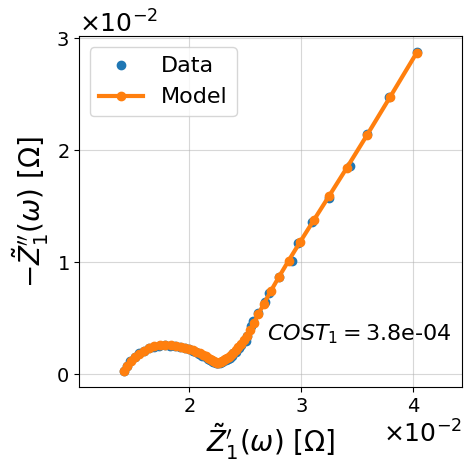

--- 0 mins 8.58 seconds ---


In [15]:
start_time = time.time()

### initialize the EIS and NLEIS string
### inductor in series with a resistor, a spherical cathode, and a planar anode
circ_str_1 = 'L0-R0-TDS0-TDP1' ## EIS string

L0 =1e-7;R0 = 0.01
Rpore = 0.06;Rct = 1e-3;Cdl = 10;Aw = 1e-4;td = 100

Rpore_a = .1;Rct_a = 2e-3;Cdl_a = 1;Aw_a = 1e-2;td_a =10

initial_guess = np.array([L0,R0,Rpore,Rct,Cdl,Aw,td,Rpore_a,Rct_a,Cdl_a,Aw_a,td_a])

fig, ax = plt.subplots(figsize=(5,5))

Z1_fit_f_50p,p1_f_50p,conf_f_50p= EIS(ax,Z1_f50,f50,initial_guess,circ_str_1,bounds = None,constants = None)

plt.tight_layout()
plt.show()
total_time = time.time() - start_time
print("--- %s mins " % int(total_time/60)+'%s seconds ---' % round(np.mod(total_time,60),2))



In [16]:
print('Parameters Set')

header=['L0','R0','Rpore,c','Rct,c','Cdl,c','Aw,c','τd,c']
print(tabulate([p1_f_50p[0:7]],headers=header))
header=['Rpore,a','Rct,a','Cdl,a','Aa','τa']
print(tabulate([p1_f_50p[7:]],headers=header))

Parameters Set
         L0         R0    Rpore,c        Rct,c    Cdl,c      Aw,c     τd,c
-----------  ---------  ---------  -----------  -------  --------  -------
1.49526e-07  0.0121632    0.12664  0.000128523  41.3674  0.001193  16.0638
  Rpore,a       Rct,a     Cdl,a           Aa        τa
---------  ----------  --------  -----------  --------
0.0107491  0.00288721  0.231914  0.000168924  0.680883


In [17]:
print('Confidence Interval')

header=['L0','R0','Rpore,c','Rct,c','Cdl,c','Aw,c','τd,c']
print(tabulate([conf_f_50p[0:7]],headers=header))
header=['Rpore,a','Rct,a','Cdl,a','Aa','τa']
print(tabulate([conf_f_50p[7:]],headers=header))


Confidence Interval
         L0           R0    Rpore,c        Rct,c    Cdl,c         Aw,c     τd,c
-----------  -----------  ---------  -----------  -------  -----------  -------
1.01376e-08  0.000168493  0.0188241  1.57691e-05  7.03808  0.000166151  1.20023
   Rpore,a        Rct,a      Cdl,a           Aa       τa
----------  -----------  ---------  -----------  -------
0.00260447  0.000452099  0.0753765  0.000289945  1.17849


### Half-Cell Results

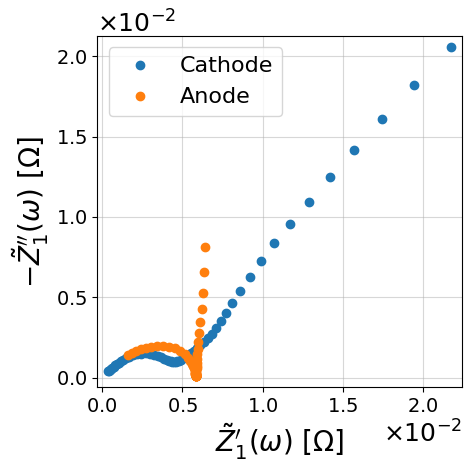

In [18]:
circuit = CustomCircuit()
circuit.circuit = 'TDS'
circuit.parameters_ = p1_f_50p[2:7]
Z1_50p_c = circuit.predict(f50)
circuit.circuit = 'TDP'
circuit.parameters_ = p1_f_50p[7:]
Z1_50p_a = circuit.predict(f50)

fig, ax = plt.subplots(figsize=(5,5))

plot_first(ax, Z1_50p_c, fmt='o')
plot_first(ax, Z1_50p_a, fmt='o')
plt.legend(['Cathode','Anode'],fontsize=16)
plt.tight_layout()
plt.show()

## Fresh Cell Summary 

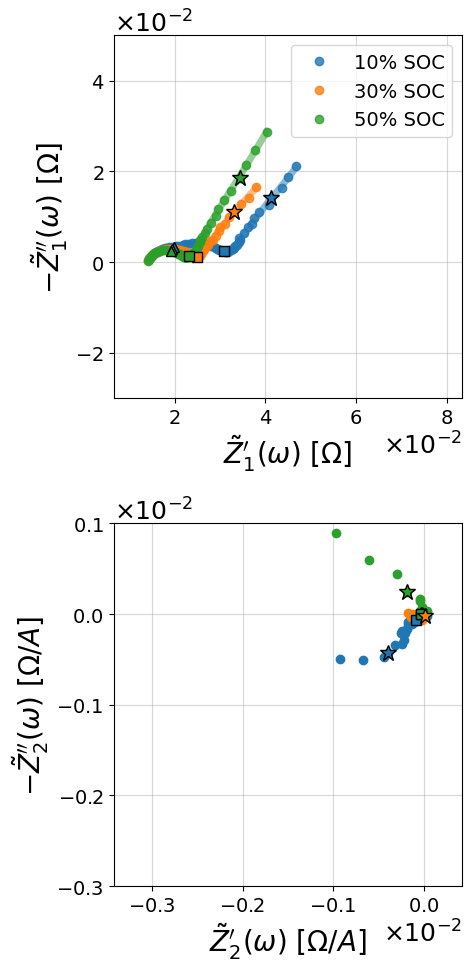

In [68]:
fig, ax = plt.subplots(2,1,figsize=(5,10))
cell_num = 1

### 10%
plot_first(ax[0],Z1_f10,fmt = 'o',alpha = 0.8, color = 'C0', label = '10% SOC')
plot_first(ax[0],Z1_fit_f_10p,fmt = '-',lw =5, alpha = 0.5, color = 'C0')

plot_second(ax[1],Z2_f10,fmt = 'o',alpha = 1, color = 'C0')

### 30%
plot_first(ax[0],Z1_f30,fmt = 'o',alpha = 0.8, color = 'C1', label = '30% SOC')
plot_first(ax[0],Z1_fit_f_30p,fmt = '-',lw =5, alpha = 0.5, color = 'C1')

plot_second(ax[1],Z2_f30,fmt = 'o',alpha = 1, color = 'C1')
### 50%
plot_first(ax[0],Z1_f50,fmt = 'o',alpha = 0.8, color = 'C2', label = '50% SOC')
plot_first(ax[0],Z1_fit_f_50p,fmt = '-',lw =5, alpha = 0.5, color = 'C2')

plot_second(ax[1],Z2_f50,fmt = 'o',alpha = 1, color = 'C2')
# plot_second(ax[1],Z2_fit_f_50p,fmt = '-',lw =5, alpha = 0.5 , color = 'C2')


## adding labels EIS
plot_first(ax[0],Z1_f10[f10==100],fmt = '^',ms = ms,color = 'C0',markeredgecolor='k')
plot_first(ax[0],Z1_f30[f30==100],fmt = '^',ms = ms,color = 'C1',markeredgecolor='k')
plot_first(ax[0],Z1_f50[f50==100],fmt = '^',ms = ms,color = 'C2',markeredgecolor='k')
plot_first(ax[0],Z1_f10[f10==1],fmt = 's',ms = ms,color = 'C0',markeredgecolor='k')
plot_first(ax[0],Z1_f30[f30==1],fmt = 's',ms = ms,color = 'C1',markeredgecolor='k')
plot_first(ax[0],Z1_f50[f50==1],fmt = 's',ms = ms,color = 'C2',markeredgecolor='k')
plot_first(ax[0],Z1_f10[f10==0.01],fmt = '*',ms = 12,color = 'C0',markeredgecolor='k')
plot_first(ax[0],Z1_f30[f30==0.01],fmt = '*',ms = 12,color = 'C1',markeredgecolor='k')
plot_first(ax[0],Z1_f50[f50==0.01],fmt = '*',ms = 12,color = 'C2',markeredgecolor='k')

## adding labels 2nd-NLEIS
plot_second(ax[1],Z2_f10[f10==100],fmt = '^',ms = ms,color = 'C0',markeredgecolor='k')
plot_second(ax[1],Z2_f30[f30==100],fmt = '^',ms = ms,color = 'C1',markeredgecolor='k')
plot_second(ax[1],Z2_f50[f50==100],fmt = '^',ms = ms,color = 'C2',markeredgecolor='k')
plot_second(ax[1],Z2_f10[f10==1],fmt = 's',ms = ms,color = 'C0',markeredgecolor='k')
plot_second(ax[1],Z2_f30[f30==1],fmt = 's',ms = ms,color = 'C1',markeredgecolor='k')
plot_second(ax[1],Z2_f50[f50==1],fmt = 's',ms = ms,color = 'C2',markeredgecolor='k')
plot_second(ax[1],Z2_f10[f10==0.01],fmt = '*',ms = 12,color = 'C0',markeredgecolor='k')
plot_second(ax[1],Z2_f30[f30==0.01],fmt = '*',ms = 12,color = 'C1',markeredgecolor='k')
plot_second(ax[1],Z2_f50[f50==0.01],fmt = '*',ms = 12,color = 'C2',markeredgecolor='k')

ax[0].set_xlim([-1e-2, 10e-2])
ax[0].set_ylim([-3e-2, 5e-2])
ax[1].set_xlim([-4e-3, 1e-3])
ax[1].set_ylim([-3e-3, 1e-3])
ax[0].legend(fontsize = 14)
# ax[1].legend(['10% SOC', '30% SOC', '50% SOC'], fontsize = 14)
ax[0].ticklabel_format(style='sci', axis='both',
                            scilimits=(-2, -2))
ax[1].ticklabel_format(style='sci', axis='both',
                            scilimits=(-2, -2))
plt.tight_layout()
plt.show()
# fig.savefig('figures/Fresh.png',dpi=300,bbox_inches='tight')

# 300 Cycle Cell Results

## Data

In [20]:
i= 1
f_300=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_freq.txt').view(float)

## 10%
Z1_300_10=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_Z1s_10_.txt').view(complex)
Z2_300_10=np.loadtxt(path+'NLEIS_worked_up_data/Cell'+str(i)+'/Cell'+str(i)+'_Z2s_10_.txt').view(complex)
mask =Z1_300_10.imag<0
f300_10 = f_300[mask]
Z1_300_10 =  Z1_300_10[mask]
Z2_300_10 =  Z2_300_10[mask]

## 30%
Z1_300_30=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_Z1s_30_.txt').view(complex)
Z2_300_30=np.loadtxt(path+'NLEIS_worked_up_data/Cell'+str(i)+'/Cell'+str(i)+'_Z2s_30_.txt').view(complex)
mask =Z1_300_30.imag<0
f300_30 = f_300[mask]

Z1_300_30 =  Z1_300_30[mask]
Z2_300_30 =  Z2_300_30[mask]

## 50%
Z1_300_50=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_Z1s_50_.txt').view(complex)
Z2_300_50=np.loadtxt(path+'NLEIS_worked_up_data/Cell'+str(i)+'/Cell'+str(i)+'_Z2s_50_.txt').view(complex)
mask =Z1_300_50.imag<0
f300_50 = f_300[mask]

Z1_300_50 =  Z1_300_50[mask]
Z2_300_50 =  Z2_300_50[mask]

## 10% SOC Results

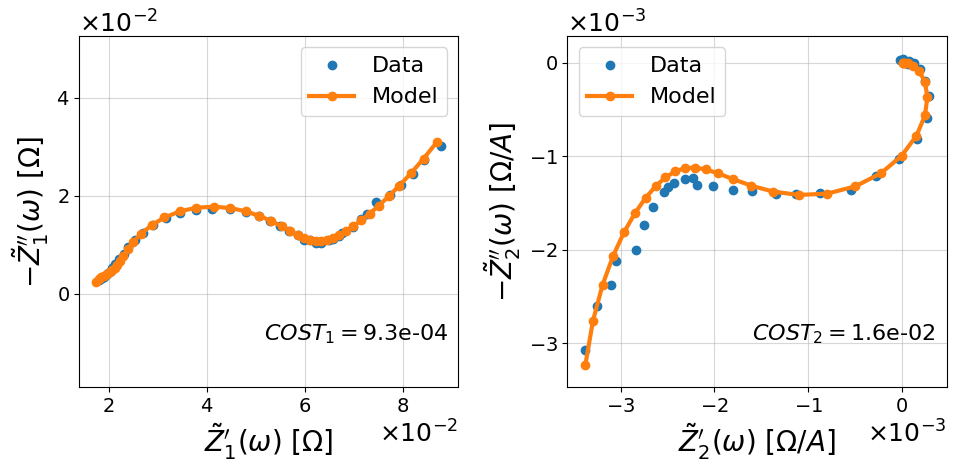

--- 0 mins 18.12 seconds ---


In [21]:
start_time = time.time()

### initialize the EIS and NLEIS string
### inductor in series with a resistor, a spherical cathode, and a planar anode
circ_str_1 = 'L0-R0-TLMS0-TDP1' ## EIS string
circ_str_2 = 'd(TLMSn0,TDPn1)' ## NLEIS string

L0 =1e-8;R0 = 0.01
Rpore = 0.002;Rct = 0.02;Cdl = 10;Aw = 1e-2;td = 1000
Rs = 1e-2; Cs = 9
κ = -10;eb = 0.02; es = 0.01
Rpore_a = .02;Rct_a = 2e-2;Cdl_a = 1;Aw_a = 1e-4;td_a =10000;k_a = -1

initial_guess = np.array([L0,R0,Rpore,Rct,Cdl,Aw,td,Rs,Cs,κ,eb,es,Rpore_a,Rct_a,Cdl_a,Aw_a,td_a,k_a])
initial_guess = np.array([ 1.68917776e-06,  1.36114829e-02,  4.76353542e-05,  1.48949401e-02,
        1.21458152e+01,  1.33145346e-01,  9.60238301e+02,  1.99042731e-02,
        4.07298688e+00, -2.92482593e+00,  3.16147361e-01,  1.00919138e-01,
        6.75024870e-02,  9.23795448e-04,  5.71335147e+00,  1.45575916e-01,
        9.99999433e+03,  2.92853166e+01])
fig, ax = plt.subplots(1,2,figsize=(10,5))

constants = {}
constants['TDPn1_6'] = 0
constants['TLMSn0_7'] = 100

mask = f300_10<100
Z1_fit_300_10p,Z2_fit_300_10p,p1_300_10p,conf_300_10p = SSO(ax[0],ax[1],Z1_300_10[mask],Z2_300_10[mask],f300_10[mask],initial_guess,circ_str_1,circ_str_2
                       ,bounds = None
                       ,sequential = False
                       ,max_f = 10,constants = constants)

plt.tight_layout()
plt.show()
total_time = time.time() - start_time
print("--- %s mins " % int(total_time/60)+'%s seconds ---' % round(np.mod(total_time,60),2))


In [22]:
print('Parameters Set')

header=['L0','R0','Rpore,c','Rct,c','Cdl,c','Aw,c','τd,c','Rs','Cs','κc','eb','es']
print(tabulate([p1_300_10p[0:12]],headers=header))
header=['Rpore,a','Rct,a','Cdl,a','Aa','τa','ka']
print(tabulate([p1_300_10p[12:]],headers=header))

Parameters Set
         L0         R0      Rpore,c      Rct,c    Cdl,c      Aw,c     τd,c         Rs       Cs        κc        eb        es
-----------  ---------  -----------  ---------  -------  --------  -------  ---------  -------  --------  --------  --------
1.51027e-06  0.0139089  6.58822e-06  0.0142799   12.795  0.132184  957.258  0.0202986  4.13157  -2.80012  0.332364  0.101888
  Rpore,a        Rct,a    Cdl,a        Aa       τa       ka
---------  -----------  -------  --------  -------  -------
0.0639835  0.000953274   5.9983  0.155022  10000.1  29.2618


In [23]:
print('Confidence Interval')

header=['L0','R0','Rpore,c','Rct,c','Cdl,c','Aw,c','τd,c','Rs','Cs','κc','eb','es']
print(tabulate([conf_300_10p[0:12]],headers=header))
header=['Rpore,a','Rct,a','Cdl,a','Aa','τa','ka']
print(tabulate([conf_300_10p[12:]],headers=header))


Confidence Interval
         L0       R0    Rpore,c     Rct,c    Cdl,c       Aw,c     τd,c          Rs        Cs       κc       eb         es
-----------  -------  ---------  --------  -------  ---------  -------  ----------  --------  -------  -------  ---------
2.96968e-05  10.7571    32.7641  0.002855  3.27226  0.0551025  567.821  0.00288234  0.354781  1.53452  0.11532  0.0166874
  Rpore,a        Rct,a    Cdl,a         Aa         τa       ka
---------  -----------  -------  ---------  ---------  -------
 0.028297  0.000687475  7.01646  0.0836179  0.0001022  12.0186


### Half Cell Results

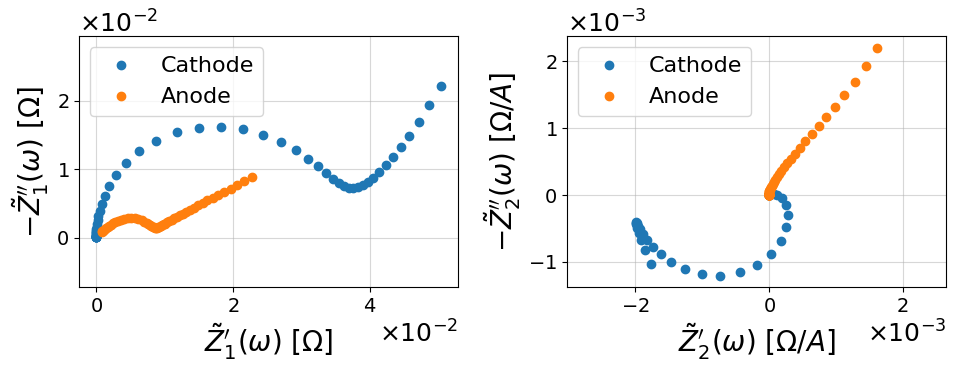

In [24]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

## EIS 
circuit = CustomCircuit()
circuit.circuit = 'TLMS'
circuit.parameters_ = p1_300_10p[2:9]

circuit.constants = {'TLMS_7':100}
Z1_300_10p_c = circuit.predict(f300_10)

circuit.circuit = 'TDP'
circuit.parameters_ = p1_300_10p[12:17]
Z1_300_10p_a = circuit.predict(f300_10)

plot_first(ax[0], Z1_300_10p_c, fmt='o')
plot_first(ax[0], Z1_300_10p_a, fmt='o')
ax[0].legend(['Cathode','Anode'],fontsize=16)

## 2nd-NLEIS
circuit = NLEISCustomCircuit()
circuit.circuit = 'TLMSn'
circuit.parameters_ = p1_300_10p[2:12]

circuit.constants = {'TLMSn_7':100}
Z2_300_10p_c = circuit.predict(f300_10)

circuit.circuit = 'TDPn'
circuit.parameters_ = p1_300_10p[12:]

circuit.constants = {'TDPn_6':0}
Z2_300_10p_a = circuit.predict(f300_10)

plot_second(ax[1], Z2_300_10p_c, fmt='o')
plot_second(ax[1], Z2_300_10p_a, fmt='o')
ax[1].legend(['Cathode','Anode'],fontsize=16)

plt.tight_layout()
plt.show()

## 30% SOC Results

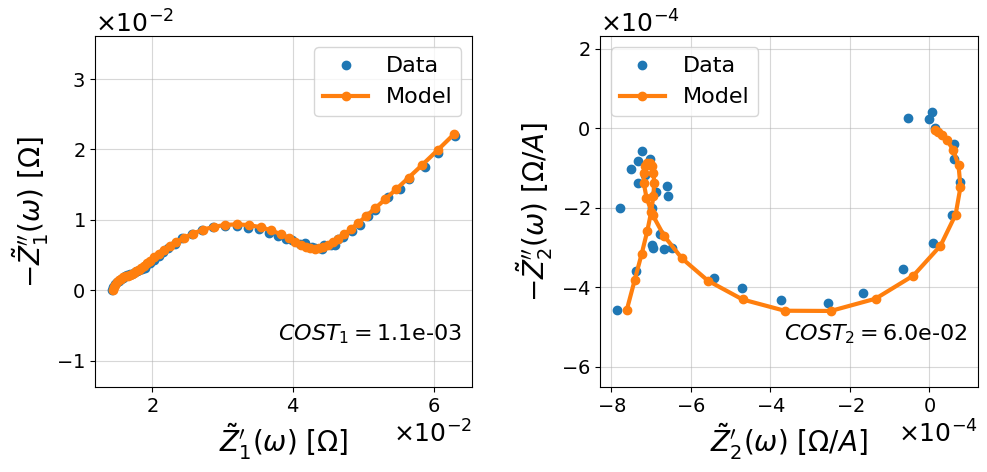

--- 0 mins 0.52 seconds ---


In [25]:
start_time = time.time()

### initialize the EIS and NLEIS string
### inductor in series with a resistor, a spherical cathode, and a planar anode
circ_str_1 = 'L0-R0-TDS0-TDP1' ## EIS string
circ_str_2 = 'd(TDSn0,TDPn1)' ## NLEIS string


L0 =1e-8;R0 = 0.01
Rpore = 0.02;Rct = 0.02;Cdl = 10;Aw = 1e-2;td = 10000

κ = -10;eb = 0.01
Rpore_a = .01;Rct_a = 1e-3;Cdl_a = 10;Aw_a = 1e-4;td_a =1000;k_a = -1


initial_guess = np.array([L0,R0,Rpore,Rct,Cdl,Aw,td,κ,eb,
                          Rpore_a,Rct_a,Cdl_a,Aw_a,td_a,k_a])

fig, ax = plt.subplots(1,2,figsize=(10,5))

constants = {}
constants['TDPn1_6'] = 0

Z1_fit_300_30p,Z2_fit_300_30p,p1_300_30p,conf_300_30p = SSO(ax[0],ax[1],Z1_300_30,Z2_300_30,f300_30,initial_guess,circ_str_1,circ_str_2
                       ,bounds = None
                       ,sequential = False
                       ,max_f = 10,constants = constants,cost = 0.5 )

plt.tight_layout()
plt.show()
total_time = time.time() - start_time
print("--- %s mins " % int(total_time/60)+'%s seconds ---' % round(np.mod(total_time,60),2))


In [26]:
print('Parameters Set')

header=['L0','R0','Rpore,c','Rct,c','Cdl,c','Aw,c','τd,c','κc','eb']
print(tabulate([p1_300_30p[0:9]],headers=header))
header=['Rpore,a','Rct,a','Cdl,a','Aa','τa','ka']
print(tabulate([p1_300_30p[9:]],headers=header))

Parameters Set
         L0         R0    Rpore,c       Rct,c    Cdl,c      Aw,c     τd,c        κc        eb
-----------  ---------  ---------  ----------  -------  --------  -------  --------  --------
1.29798e-07  0.0136113  0.0675153  0.00885273  13.0167  0.226547  9987.38  -13.7536  0.230742
    Rpore,a       Rct,a     Cdl,a         Aa       τa       ka
-----------  ----------  --------  ---------  -------  -------
1.11249e-07  0.00184601  0.218547  0.0857506  987.691  -9.5575


In [27]:
print('Confidence Interval')

header=['L0','R0','Rpore,c','Rct,c','Cdl,c','Aw,c','τd,c','κc','eb']
print(tabulate([conf_300_30p[0:9]],headers=header))
header=['Rpore,a','Rct,a','Cdl,a','Aa','τa','ka']
print(tabulate([conf_300_30p[9:]],headers=header))


Confidence Interval
         L0       R0    Rpore,c       Rct,c    Cdl,c      Aw,c     τd,c       κc         eb
-----------  -------  ---------  ----------  -------  --------  -------  -------  ---------
1.25729e-06  358.972  0.0173843  0.00109356  2.50708  0.186693  12582.5  12.7033  0.0246552
  Rpore,a        Rct,a     Cdl,a        Aa       τa      ka
---------  -----------  --------  --------  -------  ------
  1076.93  0.000993599  0.288257  0.134222  2892.08  5.9872


### Half Cell Results

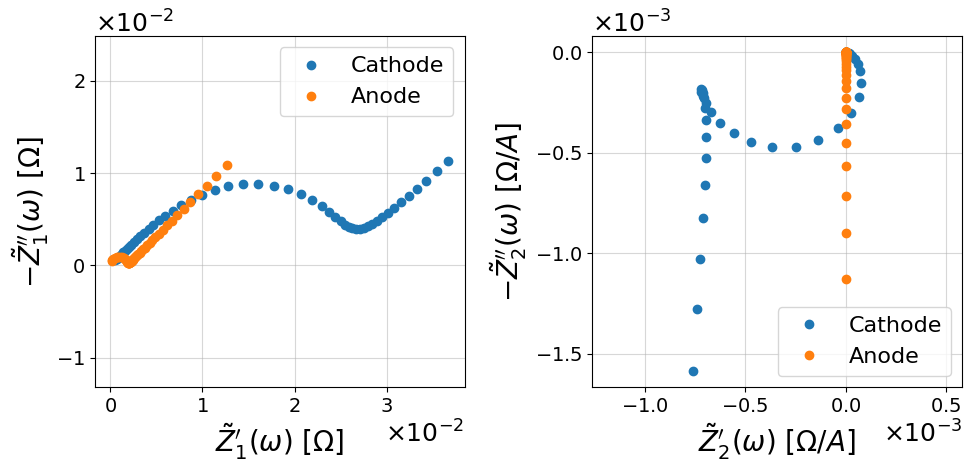

In [28]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

## EIS
circuit = CustomCircuit()
circuit.circuit = 'TDS'
circuit.parameters_ = p1_300_30p[2:7]
Z1_300_30p_c = circuit.predict(f300_30)
circuit.circuit = 'TDP'
circuit.parameters_ = p1_300_30p[9:14]
Z1_300_30p_a = circuit.predict(f300_30)

plot_first(ax[0], Z1_300_30p_c, fmt='o')
plot_first(ax[0], Z1_300_30p_a, fmt='o')
ax[0].legend(['Cathode','Anode'],fontsize=16)

## 2nd-NLEIS
circuit = NLEISCustomCircuit()
circuit.circuit = 'TDSn'
circuit.parameters_ = p1_300_30p[2:9]

Z2_300_30p_c = circuit.predict(f300_30)

circuit.circuit = 'TDPn'
circuit.parameters_ = p1_300_30p[9:]

circuit.constants = {'TDPn_6':0}
Z2_300_30p_a = circuit.predict(f300_30)

plot_second(ax[1], Z2_300_30p_c, fmt='o')
plot_second(ax[1], Z2_300_30p_a, fmt='o')
ax[1].legend(['Cathode','Anode'],fontsize=16)

plt.tight_layout()
plt.show()

## 50% SOC Results

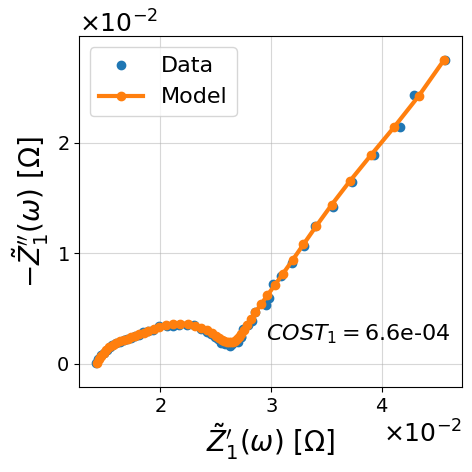

--- 0 mins 1.0 seconds ---


In [29]:
start_time = time.time()

### initialize the EIS and NLEIS string
### inductor in series with a resistor, a spherical cathode, and a planar anode
circ_str_1 = 'L0-R0-TDS0-TDP1' ## EIS string

L0 =1e-7;R0 = 0.01
Rpore = 0.02;Rct = 3e-3;Cdl = 100;Aw = 1e-4;td = 100

Rpore_a = .1;Rct_a = 1e-3;Cdl_a = 1;Aw_a = 1e-2;td_a =10


initial_guess = np.array([L0,R0,Rpore,Rct,Cdl,Aw,td,Rpore_a,Rct_a,Cdl_a,Aw_a,td_a])

fig, ax = plt.subplots(figsize=(5,5))

Z1_fit_300_50p,p1_300_50p,conf_300_50p= EIS(ax,Z1_300_50,f300_50,initial_guess,circ_str_1,bounds = None,constants = None)

plt.tight_layout()
plt.show()
total_time = time.time() - start_time
print("--- %s mins " % int(total_time/60)+'%s seconds ---' % round(np.mod(total_time,60),2))



In [30]:
print('Parameters Set')

header=['L0','R0','Rpore,c','Rct,c','Cdl,c','Aw,c','τd,c']
print(tabulate([p1_300_50p[0:7]],headers=header))
header=['Rpore,a','Rct,a','Cdl,a','Aa','τa']
print(tabulate([p1_300_50p[7:]],headers=header))

Parameters Set
         L0         R0    Rpore,c        Rct,c    Cdl,c        Aw,c     τd,c
-----------  ---------  ---------  -----------  -------  ----------  -------
1.43939e-07  0.0130087   0.121647  0.000678676  29.1651  0.00214851  57.5767
  Rpore,a        Rct,a    Cdl,a           Aa       τa
---------  -----------  -------  -----------  -------
0.0534669  0.000139485  6.30452  0.000491161  1.57256


In [31]:
print('Confidence Interval')

header=['L0','R0','Rpore,c','Rct,c','Cdl,c','Aw,c','τd,c']
print(tabulate([conf_300_50p[0:7]],headers=header))
header=['Rpore,a','Rct,a','Cdl,a','Aa','τa']
print(tabulate([conf_300_50p[7:]],headers=header))


Confidence Interval
         L0           R0    Rpore,c       Rct,c    Cdl,c       Aw,c     τd,c
-----------  -----------  ---------  ----------  -------  ---------  -------
1.56467e-08  0.000147792   0.676305  0.00376561  161.858  0.0117734  3.18688
   Rpore,a        Rct,a    Cdl,a           Aa        τa
----------  -----------  -------  -----------  --------
0.00363241  1.62223e-05  1.14968  9.06058e-05  0.200232


### Half-Cell Results

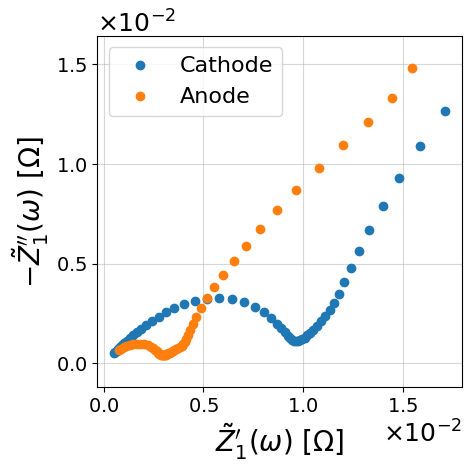

In [32]:
circuit = CustomCircuit()
circuit.circuit = 'TDS'
circuit.parameters_ = p1_300_50p[2:7]
Z1_300_50p_c = circuit.predict(f300_50)
circuit.circuit = 'TDP'
circuit.parameters_ = p1_300_50p[7:]
Z1_300_50p_a = circuit.predict(f300_50)

fig, ax = plt.subplots(figsize=(5,5))

plot_first(ax, Z1_300_50p_c, fmt='o')
plot_first(ax, Z1_300_50p_a, fmt='o')
plt.legend(['Cathode','Anode'],fontsize=16)
plt.tight_layout()
plt.show()

## 300-Cycle Cell Summary

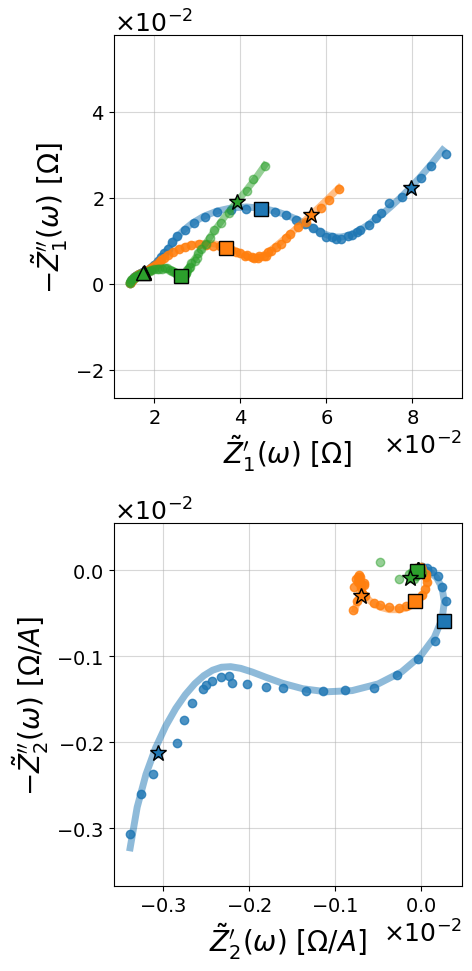

In [33]:
fig, ax = plt.subplots(2,1,figsize=(5,10))

## 10%
plot_first(ax[0],Z1_300_10,fmt = 'o',alpha = 0.8, color = 'C0', label = '10% SOC')
plot_first(ax[0],Z1_fit_300_10p,fmt = '-',lw =5, alpha = 0.5, color = 'C0')
plot_second(ax[1],Z2_300_10,fmt = 'o',alpha = 0.8, color = 'C0', label = '10% SOC')
plot_second(ax[1],Z2_fit_300_10p,fmt = '-',lw=5,alpha = 0.5, color = 'C0')

plot_first(ax[0],Z1_300_30,fmt = 'o',alpha = 0.8, color = 'C1', label = '30% SOC')
plot_first(ax[0],Z1_fit_300_30p,fmt = '-',lw =5,alpha = 0.5, color = 'C1')
plot_second(ax[1],Z2_300_30,fmt = 'o',alpha = 0.8, color = 'C1', label = '30% SOC')
plot_second(ax[1],Z2_fit_300_30p,fmt = '-',lw =5,alpha = 0.5, color = 'C1')

plot_first(ax[0],Z1_300_50,fmt = 'o',alpha = 0.5, color = 'C2', label = '50% SOC')
plot_first(ax[0],Z1_fit_300_50p,fmt = '-',lw =5,alpha = 0.5, color = 'C2')

plot_second(ax[1],Z2_300_50,fmt = 'o',alpha = 0.5, color = 'C2', label = '50% SOC')
# plot_second(ax[1],Z2_fit_300_50p,fmt = '-',lw =5,alpha = 0.5, color = 'C2')

## adding labels EIS
plot_first(ax[0],Z1_300_10[f300_10==100],fmt = '^',ms = ms,color = 'C0',markeredgecolor='k')
plot_first(ax[0],Z1_300_30[f300_30==100],fmt = '^',ms = ms,color = 'C1',markeredgecolor='k')
plot_first(ax[0],Z1_300_50[f300_50==100],fmt = '^',ms = ms,color = 'C2',markeredgecolor='k')
plot_first(ax[0],Z1_300_10[f300_10==1],fmt = 's',ms = ms,color = 'C0',markeredgecolor='k')
plot_first(ax[0],Z1_300_30[f300_30==1],fmt = 's',ms = ms,color = 'C1',markeredgecolor='k')
plot_first(ax[0],Z1_300_50[f300_50==1],fmt = 's',ms = ms,color = 'C2',markeredgecolor='k')
plot_first(ax[0],Z1_300_10[f300_10==0.01],fmt = '*',ms = 12,color = 'C0',markeredgecolor='k')
plot_first(ax[0],Z1_300_30[f300_30==0.01],fmt = '*',ms = 12,color = 'C1',markeredgecolor='k')
plot_first(ax[0],Z1_300_50[f300_50==0.01],fmt = '*',ms = 12,color = 'C2',markeredgecolor='k')

## adding labels 2nd-NLEIS
plot_second(ax[1],Z2_300_10[f300_10==100],fmt = '^',ms = ms,color = 'C0',markeredgecolor='k')
plot_second(ax[1],Z2_300_30[f300_30==100],fmt = '^',ms = ms,color = 'C1',markeredgecolor='k')
plot_second(ax[1],Z2_300_50[f300_50==100],fmt = '^',ms = ms,color = 'C2',markeredgecolor='k')
plot_second(ax[1],Z2_300_10[f300_10==1],fmt = 's',ms = ms,color = 'C0',markeredgecolor='k')
plot_second(ax[1],Z2_300_30[f300_30==1],fmt = 's',ms = ms,color = 'C1',markeredgecolor='k')
plot_second(ax[1],Z2_300_50[f300_50==1],fmt = 's',ms = ms,color = 'C2',markeredgecolor='k')
plot_second(ax[1],Z2_300_10[f300_10==0.01],fmt = '*',ms = 12,color = 'C0',markeredgecolor='k')
plot_second(ax[1],Z2_300_30[f300_30==0.01],fmt = '*',ms = 12,color = 'C1',markeredgecolor='k')
plot_second(ax[1],Z2_300_50[f300_50==0.01],fmt = '*',ms = 12,color = 'C2',markeredgecolor='k')


# ax[0].legend(fontsize = 14)
# ax[1].legend(fontsize = 14)
ax[0].ticklabel_format(style='sci', axis='both',
                            scilimits=(-2, -2))
ax[1].ticklabel_format(style='sci', axis='both',
                            scilimits=(-2, -2))

# ax[0].legend(['10% SOC', '30% SOC', '50% SOC'], fontsize = 16)
# ax[1].legend(['10% SOC', '30% SOC', '50% SOC'], fontsize = 16)
plt.tight_layout()
plt.show()
# fig.savefig('figures/300_cycles.png',dpi=300,bbox_inches='tight')

# 600 cycle Cell Results

## Data

In [34]:
i= 50
f_600=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_freq.txt').view(float)

## 10%
Z1_600_10=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_Z1s_10_.txt').view(complex)
Z2_600_10=np.loadtxt(path+'NLEIS_worked_up_data/Cell'+str(i)+'/Cell'+str(i)+'_Z2s_10_.txt').view(complex)
mask =Z1_600_10.imag<0
f600_10 = f_600[mask]
Z1_600_10 =  Z1_600_10[mask]
Z2_600_10 =  Z2_600_10[mask]

## 30%
Z1_600_30=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_Z1s_30_.txt').view(complex)
Z2_600_30=np.loadtxt(path+'NLEIS_worked_up_data/Cell'+str(i)+'/Cell'+str(i)+'_Z2s_30_.txt').view(complex)
mask =Z1_600_30.imag<0
f600_30 = f_600[mask]

Z1_600_30 =  Z1_600_30[mask]
Z2_600_30 =  Z2_600_30[mask]

## 50%
Z1_600_50=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_Z1s_50_.txt').view(complex)
Z2_600_50=np.loadtxt(path+'NLEIS_worked_up_data/Cell'+str(i)+'/Cell'+str(i)+'_Z2s_50_.txt').view(complex)
mask =Z1_600_50.imag<0
f600_50 = f_600[mask]

Z1_600_50 =  Z1_600_50[mask]
Z2_600_50 =  Z2_600_50[mask]

## 10% SOC Results

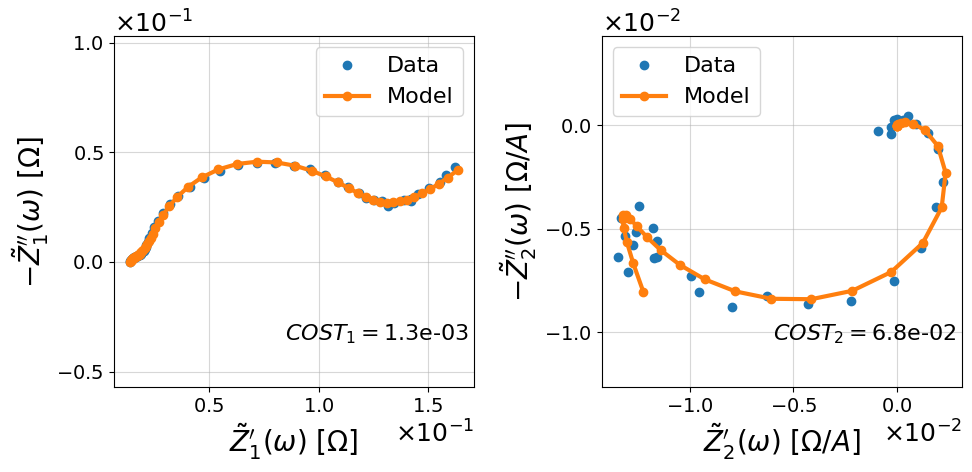

--- 4 mins 53.46 seconds ---


In [35]:
start_time = time.time()

### initialize the EIS and NLEIS string
### inductor in series with a resistor, a spherical cathode, and a planar anode
circ_str_1 = 'L0-R0-TLMS0-TDP1' ## EIS string
circ_str_2 = 'd(TLMSn0,TDPn1)' ## NLEIS string 

###### Use this unless find better one
L0 =1e-8;R0 = 0.01
Rpore = 0.02;Rct = 0.2;Cdl = 10;Aw = 1e-2;td = 1000
Rs = 0.1; Cs = 10
κ = -10;eb = 0.01; es = 0.01

Rpore_a = .02;Rct_a = 0.001;Cdl_a = 5;Aw_a = 1e-4;td_a =10000;k_a = -1



initial_guess = np.array([L0,R0,Rpore,Rct,Cdl,Aw,td,Rs,Cs,κ,eb,es,
                          Rpore_a,Rct_a,Cdl_a,Aw_a,td_a,k_a])

fig, ax = plt.subplots(1,2,figsize=(10,5))


constants = {}
constants['TDPn1_6'] = 0
constants['TLMSn0_7'] = 50

Z1_fit_600_10p,Z2_fit_600_10p,p1_600_10p,conf_600_10p = SSO(ax[0],ax[1],Z1_600_10,Z2_600_10,f600_10,initial_guess,circ_str_1,circ_str_2
                       ,bounds = None
                       ,sequential = False
                       ,max_f = 10,constants = constants)

plt.tight_layout()
plt.show()
total_time = time.time() - start_time
print("--- %s mins " % int(total_time/60)+'%s seconds ---' % round(np.mod(total_time,60),2))


In [36]:
print('Parameters Set')

header=['L0','R0','Rpore,c','Rct,c','Cdl,c','Aw,c','τd,c','Rs','Cs','κc','eb','es']
print(tabulate([p1_600_10p[0:12]],headers=header))
header=['Rpore,a','Rct,a','Cdl,a','Aa','τa','ka']
print(tabulate([p1_600_10p[12:]],headers=header))

Parameters Set
         L0         R0      Rpore,c     Rct,c    Cdl,c      Aw,c     τd,c         Rs       Cs       κc        eb        es
-----------  ---------  -----------  --------  -------  --------  -------  ---------  -------  -------  --------  --------
1.41554e-07  0.0127085  0.000730501  0.023424  24.9956  0.100896  1138.56  0.0575168  4.37421  -38.912  0.408083  0.149839
  Rpore,a        Rct,a    Cdl,a       Aa       τa       ka
---------  -----------  -------  -------  -------  -------
 0.163077  0.000103103  6.50536  0.45637  10037.6  1.84002


In [37]:
print('Confidence Interval')

header=['L0','R0','Rpore,c','Rct,c','Cdl,c','Aw,c','τd,c','Rs','Cs','κc','eb','es']
print(tabulate([conf_600_10p[0:12]],headers=header))
header=['Rpore,a','Rct,a','Cdl,a','Aa','τa','ka']
print(tabulate([conf_600_10p[12:]],headers=header))


Confidence Interval
         L0          R0    Rpore,c       Rct,c    Cdl,c       Aw,c     τd,c          Rs        Cs       κc        eb         es
-----------  ----------  ---------  ----------  -------  ---------  -------  ----------  --------  -------  --------  ---------
3.56953e-07  0.00334705  0.0290051  0.00928402  13.9813  0.0925177  814.603  0.00699347  0.413991  73.2814  0.249639  0.0273106
  Rpore,a        Rct,a    Cdl,a        Aa          τa       ka
---------  -----------  -------  --------  ----------  -------
 0.110737  0.000739863  36.1764  0.605555  3.9893e-05  1.86798


### Half-Cell Results

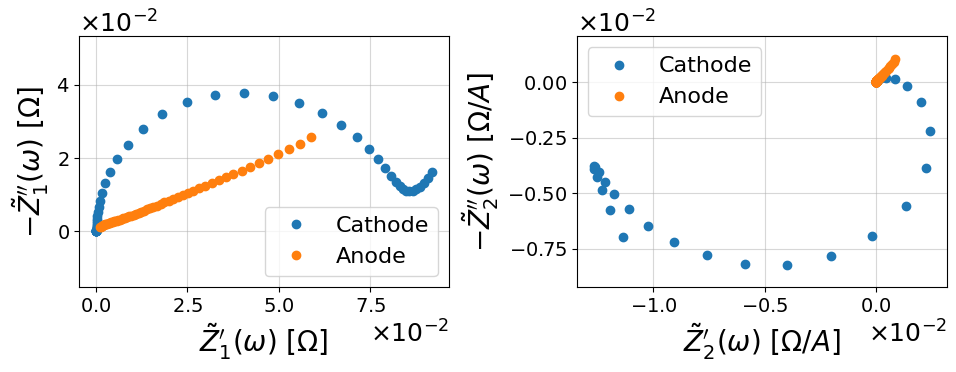

In [38]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

## EIS 
circuit = CustomCircuit()
circuit.circuit = 'TLMS'
circuit.parameters_ = p1_600_10p[2:9]

circuit.constants = {'TLMS_7':50}
Z1_600_10p_c = circuit.predict(f600_10)

circuit.circuit = 'TDP'
circuit.parameters_ = p1_600_10p[12:17]
Z1_600_10p_a = circuit.predict(f600_10)

plot_first(ax[0], Z1_600_10p_c, fmt='o')
plot_first(ax[0], Z1_600_10p_a, fmt='o')
ax[0].legend(['Cathode','Anode'],fontsize=16)

## 2nd-NLEIS
circuit = NLEISCustomCircuit()
circuit.circuit = 'TLMSn'
circuit.parameters_ = p1_600_10p[2:12]

circuit.constants = {'TLMSn_7':100}
Z2_600_10p_c = circuit.predict(f600_10)

circuit.circuit = 'TDPn'
circuit.parameters_ = p1_600_10p[12:]

circuit.constants = {'TDPn_6':0}
Z2_600_10p_a = circuit.predict(f600_10)

plot_second(ax[1], Z2_600_10p_c, fmt='o')
plot_second(ax[1], Z2_600_10p_a, fmt='o')
ax[1].legend(['Cathode','Anode'],fontsize=16)

plt.tight_layout()
plt.show()

## 30% SOC Results

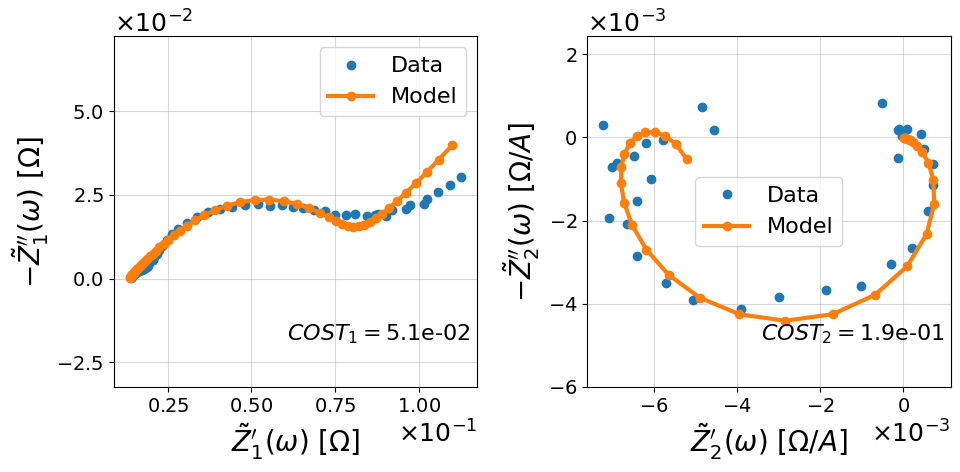

--- 0 mins 0.45 seconds ---


In [39]:
start_time = time.time()

### initialize the EIS and NLEIS string
### inductor in series with a resistor, a spherical cathode, and a planar anode
circ_str_1 = 'L0-R0-TDS0-TDP1' ## EIS string
circ_str_2 = 'd(TDSn0,TDPn1)' ## NLEIS string
###################################### Use this initial guess unless find a better one
L0 =1e-8;R0 = 0.02
Rpore = 0.01;Rct = 0.01;Cdl = 10;Aw = 1e-3;td = 1000

κ = -10;eb = 0.3
Rpore_a = 0.01;Rct_a = 1e-3;Cdl_a = 1;Aw_a = 1e-4;td_a =10000;k_a = -1
#####################################

initial_guess = np.array([L0,R0,Rpore,Rct,Cdl,Aw,td,κ,eb,
                          Rpore_a,Rct_a,Cdl_a,Aw_a,td_a,k_a])


fig, ax = plt.subplots(1,2,figsize=(10,5))

constants = {}
constants['TDPn1_6'] = 0


bounds = None 
mask = f600_30<10000
Z1_fit_600_30p,Z2_fit_600_30p,p1_600_30p,conf_600_30p = SSO(ax[0],ax[1],Z1_600_30[mask],Z2_600_30[mask],f600_30[mask],initial_guess,circ_str_1,circ_str_2
                       ,bounds = bounds
                       ,sequential = False
                       ,max_f = 10,constants = constants,cost = 0.5 )

plt.tight_layout()
plt.show()
total_time = time.time() - start_time
print("--- %s mins " % int(total_time/60)+'%s seconds ---' % round(np.mod(total_time,60),2))


In [40]:
print('Parameters Set')

header=['L0','R0','Rpore,c','Rct,c','Cdl,c','Aw,c','τd,c','κc','eb']
print(tabulate([p1_600_30p[0:9]],headers=header))
header=['Rpore,a','Rct,a','Cdl,a','Aa','τa','ka']
print(tabulate([p1_600_30p[9:]],headers=header))

Parameters Set
         L0         R0    Rpore,c      Rct,c    Cdl,c       Aw,c     τd,c       κc        eb
-----------  ---------  ---------  ---------  -------  ---------  -------  -------  --------
7.29604e-08  0.0128938   0.189483  0.0191864  18.0265  0.0715787  994.727  26.8695  0.343831
    Rpore,a        Rct,a    Cdl,a        Aa       τa       ka
-----------  -----------  -------  --------  -------  -------
1.43962e-05  5.37653e-13  15.1351  0.590777  9999.38  15.5328


In [41]:
print('Confidence Interval')

header=['L0','R0','Rpore,c','Rct,c','Cdl,c','Aw,c','τd,c','κc','eb']
print(tabulate([conf_600_30p[0:9]],headers=header))
header=['Rpore,a','Rct,a','Cdl,a','Aa','τa','ka']
print(tabulate([conf_600_30p[9:]],headers=header))

Confidence Interval
         L0         R0    Rpore,c       Rct,c    Cdl,c       Aw,c     τd,c       κc         eb
-----------  ---------  ---------  ----------  -------  ---------  -------  -------  ---------
1.52439e-06  0.0490325  0.0814187  0.00979644  10.7169  0.0568817  1749.63  163.581  0.0967595
  Rpore,a       Rct,a    Cdl,a        Aa           τa      ka
---------  ----------  -------  --------  -----------  ------
 0.149829  0.00509813  103.107  0.407524  1.22687e-05  34.689


### Half-Cell Results

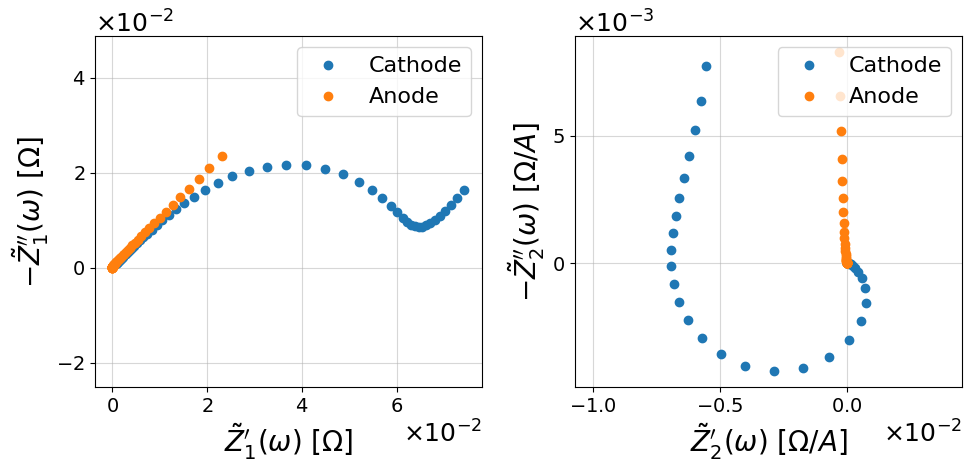

In [42]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

## EIS
circuit = CustomCircuit()
circuit.circuit = 'TDS'
circuit.parameters_ = p1_600_30p[2:7]
Z1_600_30p_c = circuit.predict(f600_30)
circuit.circuit = 'TDP'
circuit.parameters_ = p1_600_30p[9:14]
Z1_600_30p_a = circuit.predict(f600_30)

plot_first(ax[0], Z1_600_30p_c, fmt='o')
plot_first(ax[0], Z1_600_30p_a, fmt='o')
ax[0].legend(['Cathode','Anode'],fontsize=16)

## 2nd-NLEIS
circuit = NLEISCustomCircuit()
circuit.circuit = 'TDSn'
circuit.parameters_ = p1_600_30p[2:9]

Z2_600_30p_c = circuit.predict(f600_30)

circuit.circuit = 'TDPn'
circuit.parameters_ = p1_600_30p[9:]

circuit.constants = {'TDPn_6':0}
Z2_600_30p_a = circuit.predict(f600_30)

plot_second(ax[1], Z2_600_30p_c, fmt='o')
plot_second(ax[1], Z2_600_30p_a, fmt='o')
ax[1].legend(['Cathode','Anode'],fontsize=16)

plt.tight_layout()
plt.show()

## 50% SOC Results

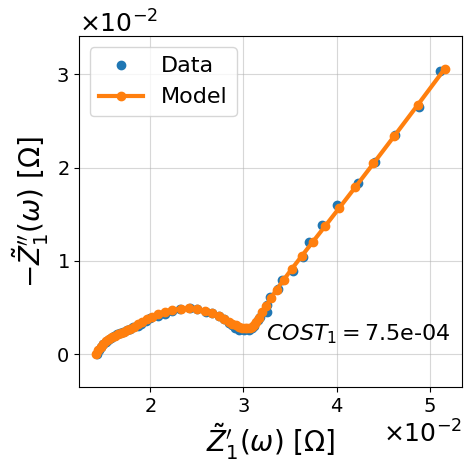

--- 0 mins 3.79 seconds ---


In [43]:
start_time = time.time()

### initialize the EIS and NLEIS string
### inductor in series with a resistor, a spherical cathode, and a planar anode
circ_str_1 = 'L0-R0-TDS0-TDP1' ## EIS string

L0 =1e-7;R0 = 0.01
Rpore = 0.02;Rct = 5e-3;Cdl = 100;Aw = 1e-4;td = 100

Rpore_a = .1;Rct_a = 1e-3;Cdl_a = 1;Aw_a = 1e-2;td_a =10


initial_guess = np.array([L0,R0,Rpore,Rct,Cdl,Aw,td,Rpore_a,Rct_a,Cdl_a,Aw_a,td_a])

fig, ax = plt.subplots(figsize=(5,5))

Z1_fit_600_50p,p1_600_50p,conf_600_50p= EIS(ax,Z1_600_50,f600_50,initial_guess,circ_str_1,bounds = None,constants = None)

plt.tight_layout()
plt.show()
total_time = time.time() - start_time
print("--- %s mins " % int(total_time/60)+'%s seconds ---' % round(np.mod(total_time,60),2))



In [44]:
print('Parameters Set')

header=['L0','R0','Rpore,c','Rct,c','Cdl,c','Aw,c','τd,c']
print(tabulate([p1_600_50p[0:7]],headers=header))
header=['Rpore,a','Rct,a','Cdl,a','Aa','τa']
print(tabulate([p1_600_50p[7:]],headers=header))

Parameters Set
         L0         R0    Rpore,c       Rct,c    Cdl,c        Aw,c     τd,c
-----------  ---------  ---------  ----------  -------  ----------  -------
1.87069e-07  0.0125805  0.0307081  0.00432618  6.65617  0.00443252  90.9406
  Rpore,a        Rct,a    Cdl,a         Aa       τa
---------  -----------  -------  ---------  -------
    0.215  4.17311e-05  12.9966  0.0004332  2.34027


In [45]:
print('Confidence Interval')

header=['L0','R0','Rpore,c','Rct,c','Cdl,c','Aw,c','τd,c']
print(tabulate([conf_600_50p[0:7]],headers=header))
header=['Rpore,a','Rct,a','Cdl,a','Aa','τa']
print(tabulate([conf_600_50p[7:]],headers=header))


Confidence Interval
         L0          R0     Rpore,c        Rct,c    Cdl,c        Aw,c     τd,c
-----------  ----------  ----------  -----------  -------  ----------  -------
2.12156e-08  0.00024589  0.00732861  0.000947853  1.73472  0.00171152  23.4622
  Rpore,a        Rct,a    Cdl,a           Aa       τa
---------  -----------  -------  -----------  -------
 0.380678  7.39536e-05  23.0853  0.000784151  0.16542


### Half-Cell Results

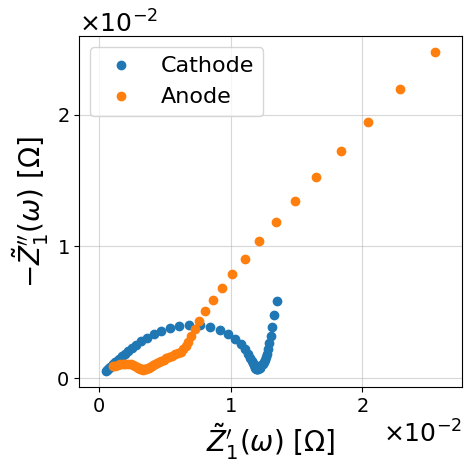

In [46]:
circuit = CustomCircuit()
circuit.circuit = 'TDS'
circuit.parameters_ = p1_600_50p[2:7]
Z1_600_50p_c = circuit.predict(f600_50)
circuit.circuit = 'TDP'
circuit.parameters_ = p1_600_50p[7:]
Z1_600_50p_a = circuit.predict(f600_50)

fig, ax = plt.subplots(figsize=(5,5))

plot_first(ax, Z1_600_50p_c, fmt='o')
plot_first(ax, Z1_600_50p_a, fmt='o')
plt.legend(['Cathode','Anode'],fontsize=16)
plt.tight_layout()
plt.show()

## 600-cycle Cell Summary

In [47]:
ms = 7

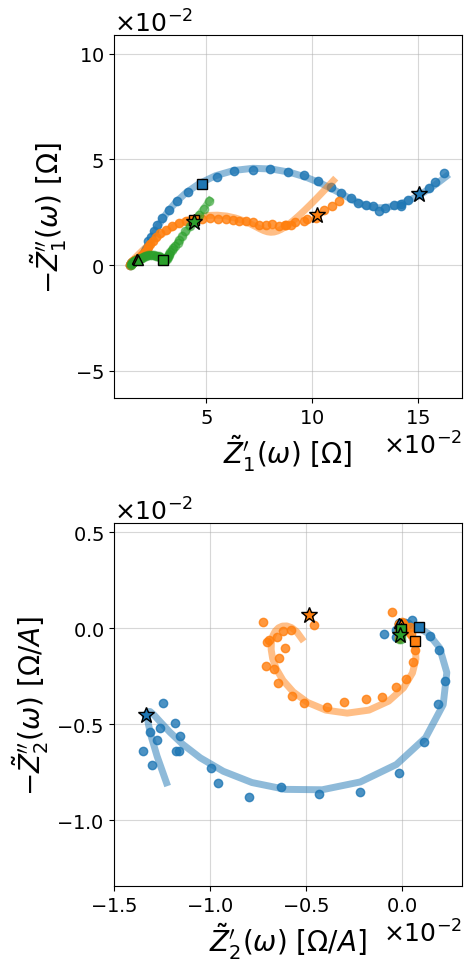

In [49]:
fig, ax = plt.subplots(2,1,figsize=(5,10))
cell_num = 1

## 10%
plot_first(ax[0],Z1_600_10,fmt = 'o',alpha = 0.8, color = 'C0', label = '10% SOC')
plot_first(ax[0],Z1_fit_600_10p,fmt = '-',lw =5, alpha = 0.5, color = 'C0')
plot_second(ax[1],Z2_600_10,fmt = 'o',alpha = 0.8, color = 'C0', label = '10% SOC')
plot_second(ax[1],Z2_fit_600_10p,fmt = '-',lw=5,alpha = 0.5, color = 'C0')
# plot_first(ax, Z1_f30[f30==100],fmt = '^',ms = ms,color = 'C0',markeredgecolor='k')


plot_first(ax[0],Z1_600_30,fmt = 'o',alpha = 0.8, color = 'C1', label = '30% SOC')
plot_first(ax[0],Z1_fit_600_30p,fmt = '-',lw =5,alpha = 0.5, color = 'C1')
plot_second(ax[1],Z2_600_30,fmt = 'o',alpha = 0.8, color = 'C1', label = '30% SOC')
plot_second(ax[1],Z2_fit_600_30p,fmt = '-',lw =5,alpha = 0.5, color = 'C1')


plot_first(ax[0],Z1_600_50,fmt = 'o',alpha = 0.5, color = 'C2', label = '50% SOC')
plot_first(ax[0],Z1_fit_600_50p,fmt = '-',lw =5,alpha = 0.5, color = 'C2')
plot_second(ax[1],Z2_600_50,fmt = 'o',alpha = 0.5, color = 'C2', label = '50% SOC')
# plot_second(ax[1],Z2_fit_600_50p,fmt = '-',lw =5,alpha = 0.5, color = 'C2')

## adding labels EIS
plot_first(ax[0],Z1_600_10[f600_10==100],fmt = '^',ms = ms,color = 'C0',markeredgecolor='k')
plot_first(ax[0],Z1_600_30[f600_30==100],fmt = '^',ms = ms,color = 'C1',markeredgecolor='k')
plot_first(ax[0],Z1_600_50[f600_50==100],fmt = '^',ms = ms,color = 'C2',markeredgecolor='k')
plot_first(ax[0],Z1_600_10[f600_10==1],fmt = 's',ms = ms,color = 'C0',markeredgecolor='k')
plot_first(ax[0],Z1_600_30[f600_30==1],fmt = 's',ms = ms,color = 'C1',markeredgecolor='k')
plot_first(ax[0],Z1_600_50[f600_50==1],fmt = 's',ms = ms,color = 'C2',markeredgecolor='k')
plot_first(ax[0],Z1_600_10[f600_10==0.01],fmt = '*',ms = 12,color = 'C0',markeredgecolor='k')
plot_first(ax[0],Z1_600_30[f600_30==0.01],fmt = '*',ms = 12,color = 'C1',markeredgecolor='k')
plot_first(ax[0],Z1_600_50[f600_50==0.01],fmt = '*',ms = 12,color = 'C2',markeredgecolor='k')

## adding labels 2nd-NLEIS
plot_second(ax[1],Z2_600_10[f600_10==100],fmt = '^',ms = ms,color = 'C0',markeredgecolor='k')
plot_second(ax[1],Z2_600_30[f600_30==100],fmt = '^',ms = ms,color = 'C1',markeredgecolor='k')
plot_second(ax[1],Z2_600_50[f600_50==100],fmt = '^',ms = ms,color = 'C2',markeredgecolor='k')
plot_second(ax[1],Z2_600_10[f600_10==1],fmt = 's',ms = ms,color = 'C0',markeredgecolor='k')
plot_second(ax[1],Z2_600_30[f600_30==1],fmt = 's',ms = ms,color = 'C1',markeredgecolor='k')
plot_second(ax[1],Z2_600_50[f600_50==1],fmt = 's',ms = ms,color = 'C2',markeredgecolor='k')
plot_second(ax[1],Z2_600_10[f600_10==0.01],fmt = '*',ms = 12,color = 'C0',markeredgecolor='k')
plot_second(ax[1],Z2_600_30[f600_30==0.01],fmt = '*',ms = 12,color = 'C1',markeredgecolor='k')
plot_second(ax[1],Z2_600_50[f600_50==0.01],fmt = '*',ms = 12,color = 'C2',markeredgecolor='k')

# ax[0].legend(fontsize = 14)
# ax[1].legend(fontsize = 14)
ax[0].ticklabel_format(style='sci', axis='both',
                            scilimits=(-2, -2))
ax[1].ticklabel_format(style='sci', axis='both',
                            scilimits=(-2, -2))
ax[1].set_xticks(np.arange(-1.5e-2,0.5e-2,0.5e-2))


# ax[0].legend(['10% SOC', '30% SOC', '50% SOC'], fontsize = 16)
# ax[1].legend(['10% SOC', '30% SOC', '50% SOC'], fontsize = 16)
plt.tight_layout()
plt.show()
# fig.savefig('figures/600_cyzcles.png',dpi=300,bbox_inches='tight')

# Summary of SOC dependence 

### Fresh 

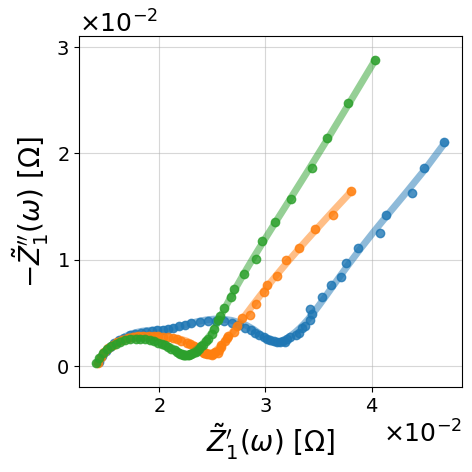

In [50]:
fig, ax = plt.subplots(figsize=(5,5))
# fig, ax = plt.subplots()

## 10%
plot_first(ax,Z1_f10,fmt = 'o',alpha = 0.8, color = 'C0', label = '10% SOC')
plot_first(ax,Z1_fit_f_10p,fmt = '-',lw =5, alpha = 0.5, color = 'C0')

plot_first(ax,Z1_f30,fmt = 'o',alpha = 0.8, color = 'C1', label = '30% SOC')
plot_first(ax,Z1_fit_f_30p,fmt = '-',lw =5, alpha = 0.5, color = 'C1')

plot_first(ax,Z1_f50,fmt = 'o',alpha = 0.8, color = 'C2', label = '50% SOC')
plot_first(ax,Z1_fit_f_50p,fmt = '-',lw =5, alpha = 0.5, color = 'C2')

# plt.xlim([0, 20e-2])
# plt.xticks(np.arange(0,20e-2,5e-2))
ax.ticklabel_format(style='sci', axis='both',
                            scilimits=(-2, -2))

plt.tight_layout()
plt.show()

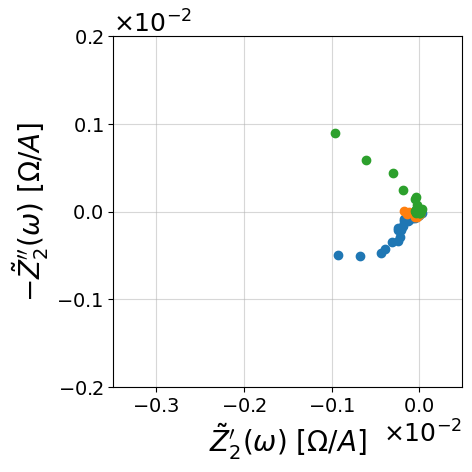

In [51]:
fig, ax = plt.subplots(figsize=(5,5))
### 10%
plot_second(ax,Z2_f10,fmt = 'o',alpha = 1, color = 'C0')

### 30%


plot_second(ax,Z2_f30,fmt = 'o',alpha = 1, color = 'C1')
### 50%

plot_second(ax,Z2_f50,fmt = 'o',alpha = 1, color = 'C2')

# ax.set_xlim([-1e-2, 8e-2])
# ax.set_ylim([-1e-2, 4e-2])
# ax.set_xlim([-1.5e-2, 0.5e-2])
# ax.set_ylim([-1.5e-2, 0.5e-2])
ax.set_xlim([-0.4e-2, 0.1e-2])
ax.set_ylim([-0.2e-2, 0.2e-2])


# ax[0].legend(fontsize = 14)
# ax.legend(['10% SOC', '30% SOC', '50% SOC'], fontsize = 14)
ax.ticklabel_format(style='sci', axis='both',
                            scilimits=(-2, -2))
# ax[1].ticklabel_format(style='sci', axis='both',
#                             scilimits=(-2, -2))
plt.tight_layout()
plt.show()
# fig.savefig('figures/Fresh.png',dpi=300,bbox_inches='tight')

### 300 EIS

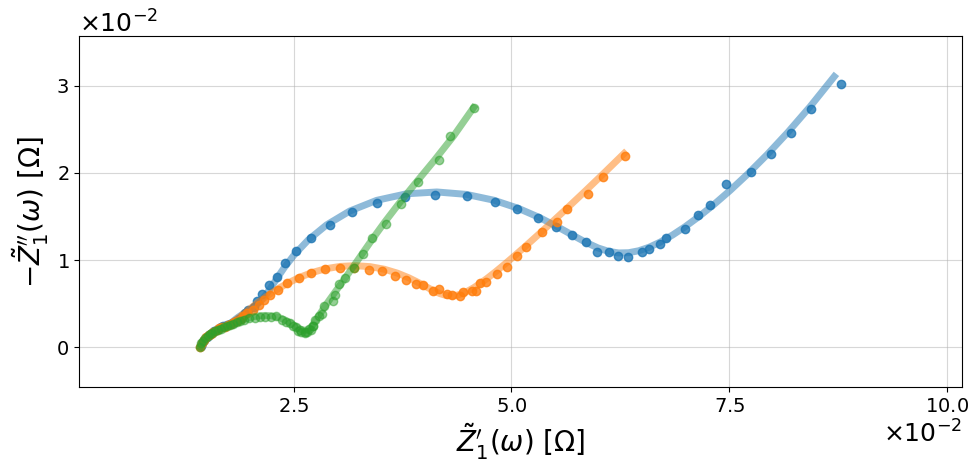

In [52]:
fig, ax = plt.subplots(figsize=(5*2,5))
# fig, ax = plt.subplots()

## 10%
plot_first(ax,Z1_300_10,fmt = 'o',alpha = 0.8, color = 'C0', label = '10% SOC')
plot_first(ax,Z1_fit_300_10p,fmt = '-',lw =5, alpha = 0.5, color = 'C0')

plot_first(ax,Z1_300_30,fmt = 'o',alpha = 0.8, color = 'C1', label = '30% SOC')
plot_first(ax,Z1_fit_300_30p,fmt = '-',lw =5,alpha = 0.5, color = 'C1')

plot_first(ax,Z1_300_50,fmt = 'o',alpha = 0.5, color = 'C2', label = '50% SOC')
plot_first(ax,Z1_fit_300_50p,fmt = '-',lw =5,alpha = 0.5, color = 'C2')



# plt.xlim([0, 20e-2])
ax.ticklabel_format(style='sci', axis='both',
                            scilimits=(-2, -2))

plt.tight_layout()
plt.show()
# fig.savefig('figures/600_cycles.png',dpi=300,bbox_inches='tight')

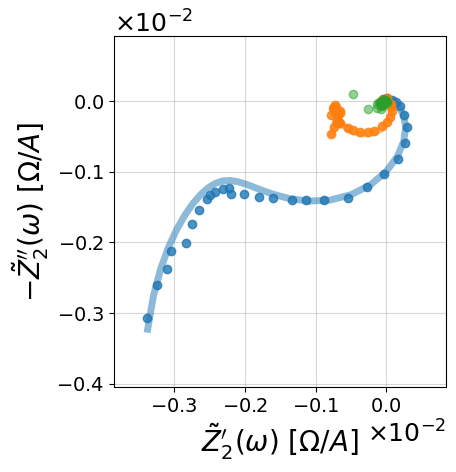

In [53]:
fig, ax = plt.subplots(figsize=(5,5))


### 10%
plot_second(ax,Z2_300_10,fmt = 'o',alpha = 0.8, color = 'C0', label = '10% SOC')
plot_second(ax,Z2_fit_300_10p,fmt = '-',lw=5,alpha = 0.5, color = 'C0')
### 30%
plot_second(ax,Z2_300_30,fmt = 'o',alpha = 0.8, color = 'C1', label = '30% SOC')
plot_second(ax,Z2_fit_300_30p,fmt = '-',lw =5,alpha = 0.5, color = 'C1')

### 50%
plot_second(ax,Z2_300_50,fmt = 'o',alpha = 0.5, color = 'C2', label = '50% SOC')
# ax.set_xticks(np.arange(-1.5e-2,0.5e-2,0.5e-2))


# ax.set_xlim([-1.5e-2, 1e-2])
# ax.set_ylim([-0.5e-2, 0.1e-2])
# ax.set_xlim([-1.5e-2, 0.5e-2])
# ax.set_ylim([-1.5e-2, 0.5e-2])

ax.set_xlim([-0.4e-2, 0.1e-2])
# ax.set_ylim([-0.2e-2, 0.2e-2])
# ax[0].legend(fontsize = 14)
# ax[1].legend(['10% SOC', '30% SOC', '50% SOC'], fontsize = 14)
ax.ticklabel_format(style='sci', axis='both',
                            scilimits=(-2, -2))
# ax[1].ticklabel_format(style='sci', axis='both',
#                             scilimits=(-2, -2))
plt.tight_layout()
plt.show()
# fig.savefig('figures/Fresh.png',dpi=300,bbox_inches='tight')

### 600 EIS

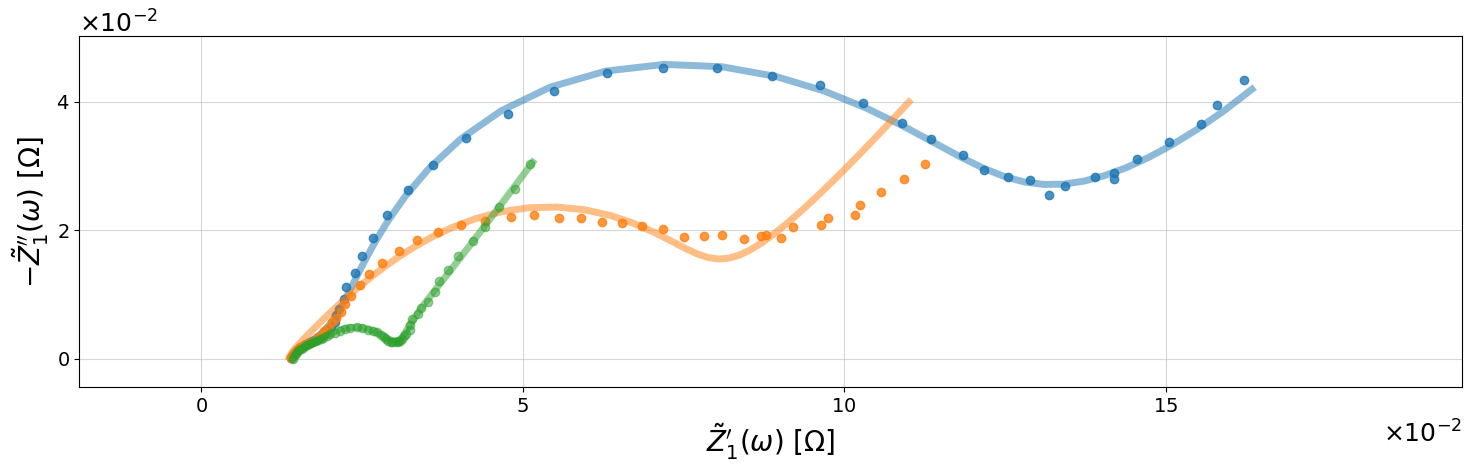

In [54]:
fig, ax = plt.subplots(figsize=(5*3,5))

## 10%
plot_first(ax,Z1_600_10,fmt = 'o',alpha = 0.8, color = 'C0', label = '10% SOC')
plot_first(ax,Z1_fit_600_10p,fmt = '-',lw =5, alpha = 0.5, color = 'C0')

plot_first(ax,Z1_600_30,fmt = 'o',alpha = 0.8, color = 'C1', label = '30% SOC')
plot_first(ax,Z1_fit_600_30p,fmt = '-',lw =5,alpha = 0.5, color = 'C1')

plot_first(ax,Z1_600_50,fmt = 'o',alpha = 0.5, color = 'C2', label = '50% SOC')
plot_first(ax,Z1_fit_600_50p,fmt = '-',lw =5,alpha = 0.5, color = 'C2')

# plt.xlim([0, 20e-2])
ax.ticklabel_format(style='sci', axis='both',
                            scilimits=(-2, -2))

plt.tight_layout()
plt.show()
# fig.savefig('figures/600_cycles.png',dpi=300,bbox_inches='tight')

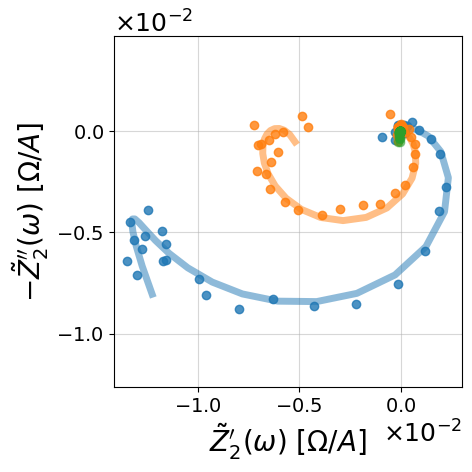

In [56]:
# fig, ax = plt.subplots(figsize=(6,6))
fig, ax = plt.subplots(figsize=(5,5))


plot_second(ax,Z2_600_10,fmt = 'o',alpha = 0.8, color = 'C0', label = '10% SOC')
plot_second(ax,Z2_fit_600_10p,fmt = '-',lw=5,alpha = 0.5, color = 'C0')

plot_second(ax,Z2_600_30,fmt = 'o',alpha = 0.8, color = 'C1', label = '30% SOC')
plot_second(ax,Z2_fit_600_30p,fmt = '-',lw =5,alpha = 0.5, color = 'C1')

plot_second(ax,Z2_600_50,fmt = 'o',alpha = 0.5, color = 'C2', label = '50% SOC')
# plot_second(ax,Z2_fit_600_50p,fmt = '-',lw =5,alpha = 0.5, color = 'C2')

# ax[0].legend(fontsize = 14)
# ax[1].legend(fontsize = 14)
ax.ticklabel_format(style='sci', axis='both',
                            scilimits=(-2, -2))
ax.ticklabel_format(style='sci', axis='both',
                            scilimits=(-2, -2))
# ax.set_xticks(np.arange(-1.5e-2,0.5e-2,0.5e-2))
# ax.set_xlim([-1.5e-2, 0.5e-2])
# ax.set_ylim([-1.5e-2, 0.5e-2])

# ax[0].legend(['10% SOC', '30% SOC', '50% SOC'], fontsize = 16)
# ax[1].legend(['10% SOC', '30% SOC', '50% SOC'], fontsize = 16)
plt.tight_layout()
plt.show()
# fig.savefig('figures/600_cycles.png',dpi=300,bbox_inches='tight')

# Parameter Extraction

In [57]:
df10 = pd.DataFrame()

df10['cycle']=[0, 300, 600]
df10['R1']=[p1_f_10p[3],p1_300_10p[3],p1_600_10p[3]]
df10['e1']=[0,p1_300_10p[10],p1_600_10p[10]]
df10['R2']=[0,p1_300_10p[7],p1_600_10p[7]]
df10['e2']=[0,p1_300_10p[11],p1_600_10p[11]]

df10['R1_err']=[conf_f_10p[3],conf_300_10p[3],conf_600_10p[3]]
df10['e1_err']=[0,conf_300_10p[10],conf_600_10p[10]]
df10['R2_err']=[0,conf_300_10p[7],conf_600_10p[7]]
df10['e2_err']=[0,conf_300_10p[11],conf_600_10p[11]]

In [58]:
df30 = pd.DataFrame()


df30['cycle']=[0, 300, 600]
df30['R1']=[p1_f_30p[3],p1_300_30p[3],p1_600_30p[3]]
df30['e1']=[0,p1_300_30p[8],p1_600_30p[8]]

df30['R2']=[0,0,0]
df30['e2']=[0,0,0]

df30['R1_err']=[conf_f_30p[3],conf_300_30p[3],conf_600_30p[3]]
df30['e1_err']=[0,conf_300_30p[8],conf_600_30p[8]]

df30['R2_err']=[0,0,0]
df30['e2_err']=[0,0,0]

In [59]:
df50 = pd.DataFrame()

df50['cycle']=[0, 300, 600]
df50['R1']=[p1_f_50p[3],p1_300_50p[3],p1_600_50p[3]]
df50['e1']=[0,0,0]
df50['R2']=[0,0,0]
df50['e2']=[0,0,0]

df50['R1_err']=[conf_f_50p[3],conf_300_50p[3],conf_600_50p[3]]
df50['e1_err']=[0,0,0]
df50['R2_err']=[0,0,0]
df50['e2_err']=[0,0,0]

In [60]:
ms = 7 
x_range = np.arange(0,900,300)

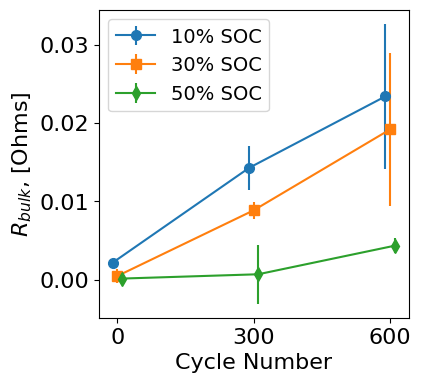

In [ ]:
fig,ax = plt.subplots(figsize = (4,4))
offset = 10
plt.errorbar(df10['cycle']-offset,df10['R1'], df10['R1_err'],fmt='-o',label = '10% SOC',ms = ms)
plt.errorbar(df30['cycle'],df30['R1'], df30['R1_err'],fmt='-s',label = '30% SOC',ms = ms)
plt.errorbar(df50['cycle']+offset,df50['R1'], df50['R1_err'],fmt='-d',label = '50% SOC',ms = ms)
plt.legend(fontsize = fontsize-2)
plt.ylabel('$R_{bulk}$, [Ohms]',fontsize = fontsize)
plt.xlabel('Cycle Number',fontsize = fontsize)
plt.xticks(x_range,fontsize = fontsize)
plt.yticks(np.arange(0,0.031,0.01),fontsize = fontsize)
plt.show()
# fig.savefig('figures/R_bulk.png',dpi=300,bbox_inches='tight')


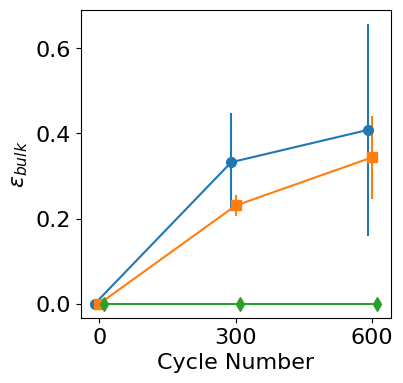

In [ ]:
fig,ax = plt.subplots(figsize = (4,4))
offset = 10
plt.errorbar(df10['cycle']-offset ,df10['e1'], df10['e1_err'],fmt='-o', label = '10% SOC',ms = ms)
plt.errorbar(df30['cycle'],df30['e1'], df30['e1_err'],fmt='-s',label = '30% SOC',ms = ms)
plt.errorbar(df50['cycle']+offset,df50['e1'], df50['e1_err'],fmt='-d',label = '50% SOC',ms = ms)
plt.ylabel('$ε_{bulk}$',fontsize = fontsize)
plt.xlabel('Cycle Number',fontsize = fontsize)
plt.xticks(x_range,fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.yticks(np.arange(0,0.71,0.2),fontsize = fontsize)

plt.show()
# fig.savefig('figures/e_bulk.png',dpi=300,bbox_inches='tight')